In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import time

from sklearn.linear_model import LinearRegression, LogisticRegression
import pysal as ps
import spacv
from spacv.grid_builder import *
from scipy.spatial.distance import pdist, squareform
from spacv.utils import *
import spreg
from shapely.geometry import Point
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PolyCollection
import math

np.set_printoptions(precision=7)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
np.printoptions(suppress=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2dev-CAPI-1.11.2 0) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [14]:
cv = spacv.HBLOCK(10,5, method='unique', buffer_radius=500, shape='square')

In [15]:
# %%timeit
for tr,te in cv.split(XYs):
    pass

                                             geometry
0   POLYGON ((10.000 3.000, 308.900 3.000, 308.900...
1   POLYGON ((308.900 3.000, 607.800 3.000, 607.80...
2   POLYGON ((607.800 3.000, 906.700 3.000, 906.70...
3   POLYGON ((906.700 3.000, 1205.600 3.000, 1205....
4   POLYGON ((1205.600 3.000, 1504.500 3.000, 1504...
5   POLYGON ((1504.500 3.000, 1803.400 3.000, 1803...
6   POLYGON ((1803.400 3.000, 2102.300 3.000, 2102...
7   POLYGON ((2102.300 3.000, 2401.200 3.000, 2401...
8   POLYGON ((2401.200 3.000, 2700.100 3.000, 2700...
9   POLYGON ((2700.100 3.000, 2999.000 3.000, 2999...
10  POLYGON ((10.000 602.200, 308.900 602.200, 308...
11  POLYGON ((308.900 602.200, 607.800 602.200, 60...
12  POLYGON ((607.800 602.200, 906.700 602.200, 90...
13  POLYGON ((906.700 602.200, 1205.600 602.200, 1...
14  POLYGON ((1205.600 602.200, 1504.500 602.200, ...
15  POLYGON ((1504.500 602.200, 1803.400 602.200, ...
16  POLYGON ((1803.400 602.200, 2102.300 602.200, ...
17  POLYGON ((2102.300 602.2

# Speed

In [2]:
n = 1000

x = np.random.randint(0, 3000, n)
y = np.random.randint(0, 3000, n)

gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(x,y)})
data = np.random.random((n,5))

y, gdf['V2'], gdf['V3'], gdf['V4'], gdf['V5'] = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
X = gdf[['V2', 'V3', 'V4', 'V5']].values

XYs = gdf['geometry']

In [31]:
cv = spacv.HBLOCK(10,5, method='unique', buffer_radius=500)

In [32]:
%%timeit
for tr,te in cv.split(XYs):
    pass

31.6 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
cv = spacv.SKCV(folds=10)

In [65]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 53s ± 3.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
cv = spacv.SKCV(folds=10, buffer_radius=500)

In [67]:
%%timeit
for tr,te in cv.split(XYs):
    pass

1min 56s ± 3.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2)

In [69]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 40s ± 1.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2, buffer_radius=500)

In [71]:
%%timeit
for tr,te in cv.split(XYs):
    pass

3min 45s ± 3.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
sample_XYs = XYs.sample(100000)

In [10]:
cv = spacv.SKCV(folds= len(sample_XYs))

In [12]:
%%timeit -r 1 -n 1
for tr,te in cv.split(sample_XYs):
    pass

8min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Sklearn integration

In [90]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

In [91]:
skcv = spacv.SKCV().split(XYs)

svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

In [92]:
clf = GridSearchCV(estimator=svc, 
                   param_grid=parameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  )

clf.fit(X, y)

In [94]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

# Ad-hoc grid/fold construction

In [41]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

model = LinearRegression(fit_intercept=True)

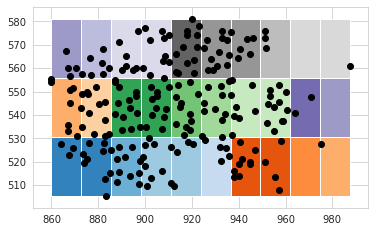

In [96]:
f, ax = plt.subplots(1)
construct_blocks(XYs, tiles_x=10, tiles_y=3, method='unique').plot(column='grid_id', cmap='tab20c',ax=ax)
XYs.plot(ax=ax, color='black')
plt.show()

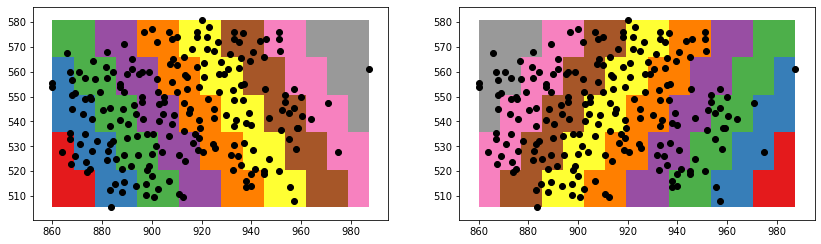

In [50]:
f, ax = plt.subplots(1,2, figsize=(14,12))

construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='anti').plot(column='grid_id', cmap='Set1', ax=ax[0])
construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='diagonal').plot(column='grid_id', cmap='Set1', ax=ax[1])

XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black');

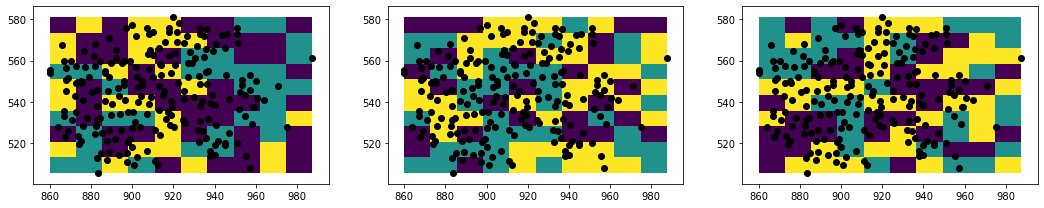

In [58]:
f, ax = plt.subplots(1,3, figsize=(18,20))
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[0])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[1])
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[2])
XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
XYs.plot(ax=ax[2], color='black');

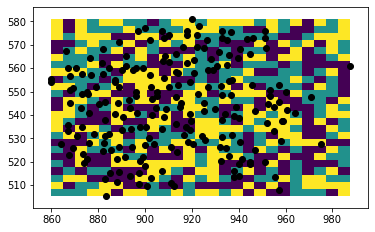

In [51]:
f, ax = plt.subplots(1)
construct_blocks(df, method='optimized_random', tiles_x=25, tiles_y=25, n_groups=3).plot(column='grid_id', ax=ax)
df.plot(ax=ax, color='black');

# Visualisaton

In [56]:
from spacv.visualisation import *

In [57]:
lags = np.arange(0, 130, 20)
bw = 10

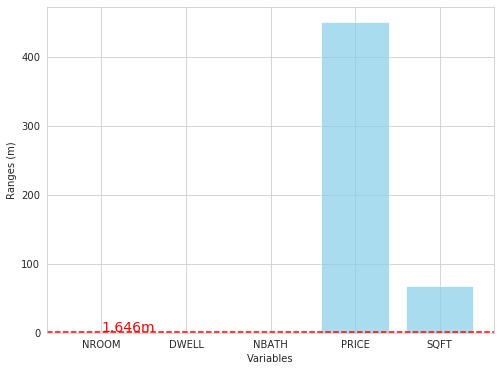

In [58]:
plot_autocorrelation_ranges(XYs, X, lags, bw)

In [97]:
plot_aoa()

Signature: plot_aoa(new_data, training_data, columns, figsize, **kwargs)
Docstring: <no docstring>
File:      ~/host/spacv/visualisation.py
Type:      function


# Future

* User specified geographies for folds.

In [2]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
X = df[['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

model = LinearRegression(fit_intercept=True)

In [3]:
def construct_hex_grid(XYs, tiles_x, tiles_y):

    minx, miny, maxx, maxy = XYs.total_bounds
    padding = 1.e-9 * (maxx - minx)
    minx -= padding
    maxx += padding
    sx = (maxx - minx) / tiles_x
    sy = (maxy - miny) / tiles_y

    nx1 = tiles_x + 1
    ny1 = tiles_y + 1
    nx2 = tiles_x
    ny2 = tiles_y
    n = nx1 * ny1 + nx2 * ny2

    offsets = np.zeros((n, 2), float)
    offsets[:nx1 * ny1, 0] = np.repeat(np.arange(nx1), ny1)
    offsets[:nx1 * ny1, 1] = np.tile(np.arange(ny1), nx1)
    offsets[nx1 * ny1:, 0] = np.repeat(np.arange(nx2) + 0.5, ny2)
    offsets[nx1 * ny1:, 1] = np.tile(np.arange(ny2), nx2) + 0.5
    offsets[:, 0] *= sx
    offsets[:, 1] *= sy
    offsets[:, 0] += minx
    offsets[:, 1] += miny

    polygon = [sx, sy / 3] * np.array(
        [[.5, -.5], [.5, .5], [0., 1.], [-.5, .5], [-.5, -.5], [0., -1.]])

    collection = PolyCollection([polygon],offsets=offsets)

    hex_polys = collection.get_paths()[0].vertices
    hex_array = []
    for xs,ys in collection.get_offsets():
        hex_x = np.add(hex_polys[:,0],  xs)
        hex_y = np.add(hex_polys[:,1],  ys)
        hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))

    hex_grid = gpd.GeoDataFrame({'geometry':hex_array})
    
    return hex_grid

<AxesSubplot:>

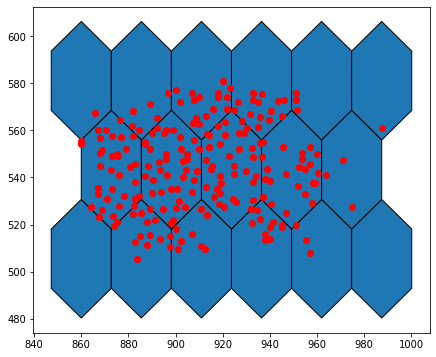

In [4]:
f,ax=plt.subplots(1, figsize=(8,6))
construct_hex_grid(XYs, 5, 1).plot(ax=ax, edgecolor='black')
# hex_grid.plot(ax=ax)
XYs.plot(ax=ax, color='red')

In [21]:
envelope = XYs.unary_union.envelope

In [22]:
env = gpd.GeoDataFrame({'geometry': [envelope]})

In [34]:
geo = gpd.overlay(geo, env, how='intersection')

<AxesSubplot:>

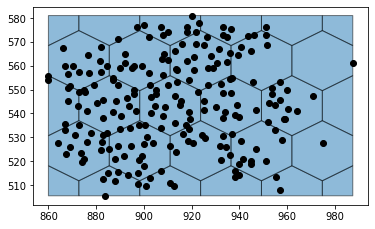

In [35]:
f,ax=plt.subplots(1)
geo.plot(ax=ax, edgecolor='black', alpha=.5)
XYs.plot(ax=ax,color='black')